In [1]:
import librosa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torchmetrics
import os
import warnings
from IPython.display import Audio
warnings.filterwarnings('ignore')
device = torch.device('cpu')

In [3]:
# config
class Config:
    SR = 16000
    N_MFCC = 70
    N_MELS = 70
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 32
    N_EPOCHS = 15
    LR = 0.0001
    MAX_DURATION = 5 # 최대 시간, 초
    SEED = 42
    PAD_SIZE = MAX_DURATION * SR # 패딩 후 크기 설정 = 샘플 수
    
CONFIG = Config()

In [4]:
def seed_everything(seed):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED)

### 데이터 읽기, 데이터 확인 작업

In [5]:
df = pd.read_csv('./fin_noise_dataframe.csv')
X = df[["id", "path"]]
y = df[["label_fake", "label_real"]]

In [6]:
X

,id,path
0,RUNQPNJF,./train/RUNQPNJF.ogg
1,JFAWUOGJ,./train/JFAWUOGJ.ogg
2,RDKEKEVX,./train/RDKEKEVX.ogg
3,QYHJDOFK,./train/QYHJDOFK.ogg
4,RSPQNHAO,./train/RSPQNHAO.ogg
...,...,...
72006,pink_noise_26,./output_with_noise/pink_noise_26.ogg
72007,white_noise_27,./output_with_noise/white_noise_27.ogg
72008,white_noise_28,./output_with_noise/white_noise_28.ogg
72009,pink_noise_29,./output_with_noise/pink_noise_29.ogg


In [7]:
y

,label_fake,label_real
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
72006,0.0,0.0
72007,0.0,0.0
72008,0.0,0.0
72009,0.0,0.0


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=CONFIG.SEED)

In [16]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [17]:
X_train.head(30)

,id,path
0,GYFSKSCU,./train/GYFSKSCU.ogg
1,LBFSEKTG,./train/LBFSEKTG.ogg
2,BDAXYDHD_noise,./output_with_noise/BDAXYDHD_noise.ogg
3,LRLYACSW,./train/LRLYACSW.ogg
4,NBCRSZQF,./train/NBCRSZQF.ogg
5,HDSIHIZI,./train/HDSIHIZI.ogg
6,AUZLGVYE,./train/AUZLGVYE.ogg
7,MVTOSXWS,./train/MVTOSXWS.ogg
8,NJILTFUF,./train/NJILTFUF.ogg
9,UELVAKPU,./train/UELVAKPU.ogg


In [18]:
y_train.tail(30)

,label_fake,label_real
43176,0.0,1.0
43177,0.0,1.0
43178,1.0,0.0
43179,1.0,0.0
43180,0.0,1.0
43181,1.0,0.0
43182,1.0,0.0
43183,1.0,0.0
43184,0.0,1.0
43185,1.0,0.0


In [72]:
root_dir = "."

def load_audio(df, root_dir):
    audios = []
    for i in tqdm(range(df.shape[0])):
        file_path = os.path.join(root_dir, df["path"][i])
        audio, sample_rate = librosa.load(file_path, sr=Config.SR)
        audio_np = np.array(audio)
        audios.append(audio_np)
    return audios

In [73]:
train_audios = load_audio(X_train, root_dir)

100%|████████████████████████████████████████████████████████████████████████████| 43206/43206 [20:27<00:00, 35.20it/s]


In [74]:
val_audios = load_audio(X_val, root_dir)

100%|████████████████████████████████████████████████████████████████████████████| 28805/28805 [13:56<00:00, 34.42it/s]


In [75]:
import numpy as np

def pad_audio(audio, target_length):
    if len(audio) < target_length:
        pad_width = target_length - len(audio)
        left = pad_width // 2
        right = pad_width - left
        padded_audio = np.pad(audio, (left, right), mode='constant')
    else:
        padded_audio = audio[:target_length]
    return padded_audio

target_length = 16000*5

train_audios_padded = [pad_audio(audio, target_length) for audio in tqdm(train_audios)]
val_audios_padded = [pad_audio(audio, target_length) for audio in tqdm(val_audios)]

100%|███████████████████████████████████████████████████████████████████████████| 28805/28805 [02:25<00:00, 198.50it/s]


## 노이즈 병합

In [21]:
import scipy.io.wavfile as wavfile
import numpy as np

# 화이트 노이즈 생성
duration = 5  # 초
sample_rate = 16000  # Hz
num_samples = duration * sample_rate
num_channels = 2  # 스테레오

# 화이트 노이즈 생성
white_noise = np.random.normal(0, 1, (num_samples, num_channels))

# 16비트 PCM 범위로 정규화
white_noise = np.int16(white_noise / np.max(np.abs(white_noise)) * 32767)

# 출력 경로 설정
output_path = './new_noise/white_noise.wav'

# 화이트 노이즈를 WAV 파일로 저장
wavfile.write(output_path, sample_rate, white_noise)

print(f"화이트 노이즈 파일이 생성되었습니다: {output_path}")

화이트 노이즈 파일이 생성되었습니다: ./new_noise/white_noise.wav


In [29]:
import numpy as np
import scipy.io.wavfile as wavfile
import random

def generate_white_noise(duration, sample_rate, num_channels):
    num_samples = duration * sample_rate
    white_noise = np.random.normal(0, 1, (num_samples, num_channels))
    return np.int16(white_noise / np.max(np.abs(white_noise)) * 32767)

def generate_pink_noise(duration, sample_rate, num_channels):
    num_samples = duration * sample_rate
    num_samples_per_channel = num_samples // num_channels
    pink_noise = np.zeros((num_samples_per_channel, num_channels))
    for i in range(num_channels):
        # 간단한 핑크 노이즈 알고리즘
        pink_noise[:, i] = np.random.normal(0, 1, num_samples_per_channel) * np.linspace(1, 0.5, num_samples_per_channel)
    return np.int16(pink_noise / np.max(np.abs(pink_noise)) * 32767)

def generate_brown_noise(duration, sample_rate, num_channels):
    num_samples = duration * sample_rate
    brown_noise = np.zeros((num_samples, num_channels))
    for i in range(num_channels):
        white_noise = np.random.normal(0, 1, num_samples)
        brown_noise[:, i] = np.cumsum(white_noise)
    return np.int16(brown_noise / np.max(np.abs(brown_noise)) * 32767)


def generate_random_sounds(num_sounds, duration, sample_rate, num_channels, output_folder):
    noise_types = ['white', 'pink', 'brown']
    for i in range(num_sounds):
        noise_type = random.choice(noise_types)
        if noise_type == 'white':
            noise = generate_white_noise(duration, sample_rate, num_channels)
            wavfile.write(f'{output_folder}/white_noise_{i+1}.wav', sample_rate, noise)
        elif noise_type == 'pink':
            noise = generate_pink_noise(duration, sample_rate, num_channels)
            wavfile.write(f'{output_folder}/pink_noise_{i+1}.wav', sample_rate, noise)
        elif noise_type == 'brown':
            noise = generate_brown_noise(duration, sample_rate, num_channels)
            wavfile.write(f'{output_folder}/brown_noise_{i+1}.wav', sample_rate, noise)

# 설정
duration = 5  # 초
sample_rate = 16000  # Hz
num_channels = 2  # 스테레오
num_sounds = 30  # 생성할 소리 수
output_folder = './new_noise'  # 출력 폴더

# 랜덤 소리 생성
generate_random_sounds(num_sounds, duration, sample_rate, num_channels, output_folder)

print("30개의 랜덤 소리 파일이 생성되었습니다.")


30개의 랜덤 소리 파일이 생성되었습니다.


In [39]:
import os
import random
import pandas as pd
from pydub import AudioSegment

# combined_dataframe.csv 파일 경로
combined_df_path = './combined_dataframe.csv'

# 평가용 오디오 샘플 디렉토리
eval_audio_dir1 = './open/train_overlay'
eval_audio_dir2 = './'

# 노이즈 파일 디렉토리
noise_audio_dir = './new_noise'

output_dir = './output_with_noise'
os.makedirs(output_dir, exist_ok=True)

combined_df = pd.read_csv(combined_df_path)

# 평가용 오디오 샘플 경로 리스트
eval_audio_paths = combined_df['path'].tolist()

# 전체 샘플 선택
num_samples = len(eval_audio_paths)
num_samples_to_modify = num_samples // 10
samples_to_modify = random.sample(eval_audio_paths, num_samples_to_modify)

# 노이즈 파일 리스트
noise_files = [f for f in os.listdir(noise_audio_dir) if f.endswith('.wav')]

new_rows = []

for sample_path in tqdm(samples_to_modify):
    
    full_path = os.path.join(eval_audio_dir1, sample_path)
    
    if os.path.exists(full_path):
        eval_audio = AudioSegment.from_ogg(full_path)
    else:
        eval_audio = AudioSegment.from_ogg(os.path.join(eval_audio_dir2, sample_path))

    
    # 랜덤 노이즈 파일 선택 및 로드
    noise_file = random.choice(noise_files)
    noise_audio = AudioSegment.from_ogg(os.path.join(noise_audio_dir, noise_file))
    
    # 평가용 오디오와 노이즈 길이 맞추기 (필요시 노이즈 반복)
    if len(noise_audio) < len(eval_audio):
        noise_audio = noise_audio * (len(eval_audio) // len(noise_audio) + 1)
    noise_audio = noise_audio[:len(eval_audio)]
    
    # 노이즈 오버레이
    combined_audio = eval_audio.overlay(noise_audio)
    
     # 새로운 파일 경로 설정 및 저장
    base_filename = os.path.splitext(os.path.basename(sample_path))[0]
    new_file_name = f"{base_filename}_noise.ogg"
    new_file_path = os.path.join(output_dir, new_file_name)
    combined_audio.export(new_file_path, format='ogg')
    
    # 새로운 행 추가 (기존 정보 복사)
    label_fake = combined_df.loc[combined_df['path'] == sample_path, 'label_fake'].values[0]
    label_real = combined_df.loc[combined_df['path'] == sample_path, 'label_real'].values[0]
    
    new_rows.append({
        'id': f"{base_filename}_noise",
        'path': new_file_path,
        'label_fake': label_fake,
        'label_real': label_real
    })
    
# 새로운 행을 데이터프레임으로 변환하고 추가
new_df = pd.DataFrame(new_rows)
#combined_df = pd.concat([combined_df, new_df], ignore_index=True)

# 업데이트된 데이터프레임을 CSV로 저장
#combined_df.to_csv(combined_df_path, index=False)    
    
print(f"{num_samples_to_modify}개의 샘플에 노이즈가 오버레이되었습니다.")


100%|██████████████████████████████████████████████████████████████████████████████| 6543/6543 [40:56<00:00,  2.66it/s]

6543개의 샘플에 노이즈가 오버레이되었습니다.


In [48]:
# 경로 수정: 맨 앞에 './' 추가
new_df['path'] = './' + new_df['path']

In [49]:
new_df

,id,path,label_fake,label_real
0,BZCNGVFI_noise,./output_with_noise/BZCNGVFI_noise.ogg,1.0,0.0
1,WFXYNVOR_noise,./output_with_noise/WFXYNVOR_noise.ogg,0.0,1.0
2,LYSSPPLZ_noise,./output_with_noise/LYSSPPLZ_noise.ogg,1.0,0.0
3,made_UKWBCIZ_noise,./output_with_noise/made_UKWBCIZ_noise.ogg,1.0,1.0
4,TPVNIODB_noise,./output_with_noise/TPVNIODB_noise.ogg,1.0,0.0
...,...,...,...,...
6538,ENLCUWXC_noise,./output_with_noise/ENLCUWXC_noise.ogg,1.0,0.0
6539,RMHMQVES_noise,./output_with_noise/RMHMQVES_noise.ogg,1.0,0.0
6540,KPUVJWLX_noise,./output_with_noise/KPUVJWLX_noise.ogg,1.0,0.0
6541,MQDSZBKP_noise,./output_with_noise/MQDSZBKP_noise.ogg,0.0,1.0


In [50]:
noise_combined_df = pd.concat([df, new_df], ignore_index=True)

In [51]:
noise_combined_df

,id,path,label_fake,label_real
0,RUNQPNJF,./train/RUNQPNJF.ogg,0.0,1.0
1,JFAWUOGJ,./train/JFAWUOGJ.ogg,1.0,0.0
2,RDKEKEVX,./train/RDKEKEVX.ogg,0.0,1.0
3,QYHJDOFK,./train/QYHJDOFK.ogg,0.0,1.0
4,RSPQNHAO,./train/RSPQNHAO.ogg,0.0,1.0
...,...,...,...,...
71976,ENLCUWXC_noise,./output_with_noise/ENLCUWXC_noise.ogg,1.0,0.0
71977,RMHMQVES_noise,./output_with_noise/RMHMQVES_noise.ogg,1.0,0.0
71978,KPUVJWLX_noise,./output_with_noise/KPUVJWLX_noise.ogg,1.0,0.0
71979,MQDSZBKP_noise,./output_with_noise/MQDSZBKP_noise.ogg,0.0,1.0


In [52]:
noise_combined_df.to_csv('./noise_dataframe.csv', index=False)    

In [53]:
import numpy as np
import random
import os
from pydub import AudioSegment
from scipy.io.wavfile import write

def generate_white_noise(duration, sample_rate, num_channels):
    num_samples = duration * sample_rate
    white_noise = np.random.normal(0, 1, (num_samples, num_channels))
    return np.int16(white_noise / np.max(np.abs(white_noise)) * 32767)

def generate_pink_noise(duration, sample_rate, num_channels):
    num_samples = duration * sample_rate
    pink_noise = np.zeros((num_samples, num_channels))
    for i in range(num_channels):
        # 간단한 핑크 노이즈 알고리즘
        pink_noise[:, i] = np.random.normal(0, 1, num_samples) * np.linspace(1, 0.5, num_samples)
    return np.int16(pink_noise / np.max(np.abs(pink_noise)) * 32767)

def save_noise_as_ogg(noise, sample_rate, output_path):
    # WAV 파일로 저장 후 OGG로 변환
    temp_wav_path = output_path.replace('.ogg', '.wav')
    write(temp_wav_path, sample_rate, noise)  # WAV 파일 저장
    audio = AudioSegment.from_wav(temp_wav_path)  # WAV 파일 읽기
    audio.export(output_path, format='ogg')  # OGG 파일로 저장
    os.remove(temp_wav_path)  # 임시 WAV 파일 삭제

def generate_random_sounds(num_sounds, duration, sample_rate, num_channels, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # 폴더 생성
    new_rows = []
    noise_types = ['white', 'pink']
    for i in range(num_sounds):
        noise_type = random.choice(noise_types)
        if noise_type == 'white':
            noise = generate_white_noise(duration, sample_rate, num_channels)
            noise_id = f'white_noise_{i+1}'
            output_path = f'{output_folder}/{noise_id}.ogg'
            save_noise_as_ogg(noise, sample_rate, output_path)  # OGG로 저장
        elif noise_type == 'pink':
            noise = generate_pink_noise(duration, sample_rate, num_channels)
            noise_id = f'pink_noise_{i+1}'
            output_path = f'{output_folder}/{noise_id}.ogg'
            save_noise_as_ogg(noise, sample_rate, output_path)  # OGG로 저장
            
        # 새로운 행 추가 
        new_rows.append({
            'id': noise_id,
            'path': output_path,
            'label_fake': 0.0,
            'label_real': 0.0
        })

    return new_rows

# 설정
duration = 5  # 초
sample_rate = 16000  # Hz
num_channels = 2  # 스테레오
num_sounds = 30  # 생성할 소리 수
output_folder = './output_with_noise'  # 출력 폴더

# 랜덤 소리 생성 및 정보 수집
generated_sounds_info = generate_random_sounds(num_sounds, duration, sample_rate, num_channels, output_folder)

print("30개의 랜덤 소리 파일이 OGG 형식으로 생성되었습니다.")

30개의 랜덤 소리 파일이 OGG 형식으로 생성되었습니다.


In [54]:
new_df = pd.DataFrame(generated_sounds_info)

In [56]:
ori_df = pd.read_csv('./noise_dataframe.csv')
noise_df = pd.concat([ori_df, new_df], ignore_index=True)

In [58]:
noise_df.to_csv('./fin_noise_dataframe.csv', index=False)    

## Melspectrogram, mfcc

In [77]:
def extract_feature(audios, mfcc=True):
    features = []
    if mfcc: #mfcc로 피처를 추출하고 싶을 때
        for audio in tqdm(audios):
            mfcc_feature = librosa.feature.mfcc(y=audio, sr=CONFIG.SR, n_mfcc=CONFIG.N_MFCC)
            mfcc_feature = np.mean(mfcc_feature.T, axis=0)
            features.append(mfcc_feature)
    else: #mel로 피처 추출하고 싶을 때
        for audio in tqdm(audios):
            mel_feature = librosa.feature.melspectrogram(y=audio, sr=CONFIG.SR, n_mels=CONFIG.N_MELS)
            mel_feature = librosa.power_to_db(mel_feature, ref=np.max)
            features.append(mel_feature)
    return np.array(features)

In [78]:
mfcc_X_train_features = extract_feature(train_audios_padded, mfcc=True)
mfcc_X_val_features = extract_feature(val_audios_padded, mfcc=True)

100%|████████████████████████████████████████████████████████████████████████████| 28805/28805 [29:09<00:00, 16.46it/s]


In [79]:
np.save('./noise_features/mfcc_X_train_features', mfcc_X_train_features)
np.save('./noise_features/mfcc_X_val_features', mfcc_X_val_features)

In [9]:
mfcc_X_train_features = np.load('./noise_features/mfcc_X_train_features.npy')
mfcc_X_val_features = np.load('./noise_features/mfcc_X_val_features.npy')

In [9]:
mfcc_X_train_features = np.load('./noise_features/mfcc_X_train_features.npy')
mfcc_X_val_features = np.load('./noise_features/mfcc_X_val_features.npy')

In [10]:
print("mfcc_X_train_features.shape",mfcc_X_train_features.shape)
#((47122, 13)): (샘플 수, mfcc 계수)
print("mfcc_X_val_features.shape",mfcc_X_val_features.shape)

mfcc_X_train_features.shape (43206, 70)
mfcc_X_val_features.shape (28805, 70)


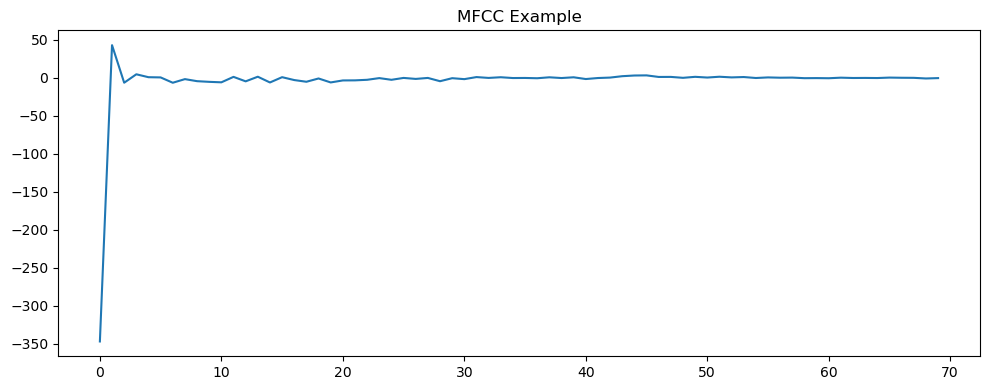

In [11]:
import matplotlib.pyplot as plt

# Mel-spectrogram 시각화
def plot_mel_spectrogram(mel_spectrogram, title='Mel-Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    
# MFCC 시각화
def plot_mfcc(mfcc, title='MFCC'):
    plt.figure(figsize=(10, 4))
    plt.plot(mfcc)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 예시 Mel-spectrogram 시각화
#plot_mel_spectrogram(mel_X_train_features[0], title='Mel-Spectrogram Example')

# 예시 MFCC 시각화
plot_mfcc(mfcc_X_train_features[1], title='MFCC Example')


### 모델 생성

In [12]:
import tensorflow as tf

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

## 라벨 분리

In [19]:
y_train

,label_fake,label_real
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0
...,...,...
43201,1.0,0.0
43202,1.0,0.0
43203,0.0,1.0
43204,0.0,1.0


In [20]:
y_train = np.array(y_train)
y_val = np.array(y_val)

# labels_fake와 labels_real 분리
y_train_fake = y_train[:,0]
y_train_real = y_train[:,1]
y_val_fake = y_val[:,0]
y_val_real = y_val[:,1]

# 출력 확인
print(y_train_fake)
print(y_train_real)
print(y_val_fake)
print(y_val_real)

[1. 1. 1. ... 0. 0. 1.]
[0. 0. 0. ... 1. 1. 0.]
[0. 0. 0. ... 0. 0. 1.]
[1. 1. 1. ... 1. 1. 0.]


In [21]:
def inference(model, test_dataset):
    predictions = []
    for features in tqdm(test_dataset):
        probs = model(features, training=False)
        predictions.extend(probs.numpy().tolist())
    return predictions

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation, LSTM, Reshape
from tensorflow.keras.layers import Bidirectional

def mfcc_cnn_lstm(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.8))

    model.add(Conv1D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.8))

    # LSTM 
    # model.add(LSTM(64, return_sequences=True))
    # model.add(LSTM(64))  
    # 결과: 0.39317 -> cnn만을 사용했을 때보다 0.03정도 낮아짐
    
    #LSTM 대신 BiLstm으로 교체해봄 0.3792214873	
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(1, activation='sigmoid'))

    return model

input_shape_mfcc = (70, 1)  # (timesteps, features)
num_classes = 1

model2_fake = mfcc_cnn_lstm(input_shape_mfcc, num_classes)
model2_real = mfcc_cnn_lstm(input_shape_mfcc, num_classes)

model2_fake.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2_real.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# 데이터 변환 (timesteps, features) 형태로
mfcc_X_train_features_reshaped = mfcc_X_train_features.reshape(mfcc_X_train_features.shape[0], mfcc_X_train_features.shape[1], 1)
mfcc_X_val_features_reshaped = mfcc_X_val_features.reshape(mfcc_X_val_features.shape[0], mfcc_X_val_features.shape[1], 1)

hist_fake = model2_fake.fit(mfcc_X_train_features_reshaped, y_train_fake, 
                 validation_data=(mfcc_X_val_features_reshaped, y_val_fake), 
                 epochs=15, batch_size=32, callbacks=[es], verbose=1)

hist_real = model2_real.fit(mfcc_X_train_features_reshaped, y_train_real, 
                 validation_data=(mfcc_X_val_features_reshaped, y_val_real), 
                 epochs=15, batch_size=32, callbacks=[es], verbose=1)

Epoch 1/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.7659 - loss: 0.4966 - val_accuracy: 0.7251 - val_loss: 0.6441
Epoch 2/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.8320 - loss: 0.3996 - val_accuracy: 0.7466 - val_loss: 0.5134
Epoch 3/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.8478 - loss: 0.3702 - val_accuracy: 0.7986 - val_loss: 0.4187
Epoch 4/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.8561 - loss: 0.3555 - val_accuracy: 0.8402 - val_loss: 0.3894
Epoch 5/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.8610 - loss: 0.3428 - val_accuracy: 0.8222 - val_loss: 0.3855
Epoch 6/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.8688 - loss: 0.3322 - val_accuracy: 0.8179 - val_loss: 0.4104
Epoch 7/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.8696 - loss: 0.3254 - val_accuracy: 0.8421 - val_loss: 0.3606
Epoch 8/15
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.8786 -

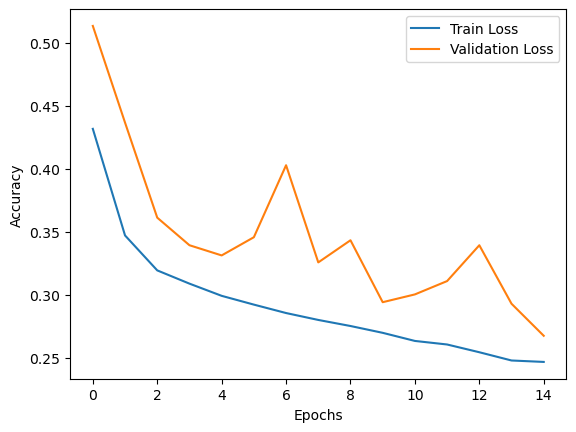

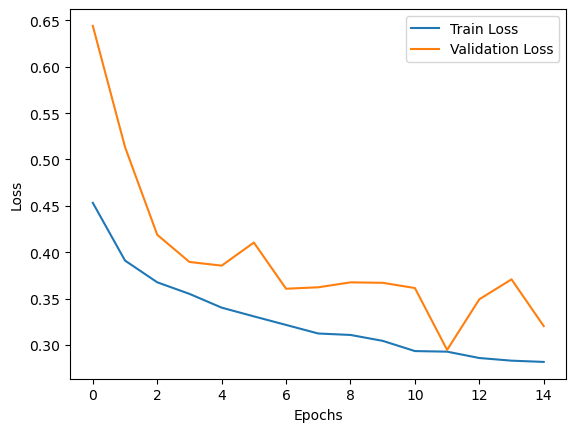

In [23]:
import matplotlib.pyplot as plt

plt.plot(hist_real.history['loss'], label='Train Loss')
plt.plot(hist_real.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist_fake.history['loss'], label='Train Loss')
plt.plot(hist_fake.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
test = pd.read_csv('./test.csv')
print(test.head())

test = load_audio(test, root_dir)

test_mfcc = extract_feature(test, mfcc=True)

           id                   path
0  TEST_00000  ./test/TEST_00000.ogg
1  TEST_00001  ./test/TEST_00001.ogg
2  TEST_00002  ./test/TEST_00002.ogg
3  TEST_00003  ./test/TEST_00003.ogg
4  TEST_00004  ./test/TEST_00004.ogg


  0%|                                                                             | 47/50000 [00:03<1:06:25, 12.53it/s]


KeyboardInterrupt: 

In [39]:
np.save('./0702/mfcc_test_features.npy', test_mfcc)

In [24]:
mfcc_test_features = np.load('./0702/mfcc_test_features.npy')

In [26]:
import tensorflow as tf

test_dataset = tf.data.Dataset.from_tensor_slices(mfcc_test_features).batch(CONFIG.BATCH_SIZE)

In [27]:
fake_preds = inference(model2_fake, test_dataset)
real_preds = inference(model2_real, test_dataset)

100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [06:32<00:00,  3.98it/s]


In [28]:
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1] = fake_preds
submit.iloc[:, 2] = real_preds
submit.head(60)

,id,fake,real
0,TEST_00000,0.340853,0.767534
1,TEST_00001,0.397116,0.958694
2,TEST_00002,0.356130,0.972726
3,TEST_00003,0.173116,0.552545
4,TEST_00004,0.066275,0.983605
5,TEST_00005,0.161950,0.992275
6,TEST_00006,0.144977,0.828413
7,TEST_00007,0.063608,0.903683
8,TEST_00008,0.031032,0.899810
9,TEST_00009,0.937383,0.787757


In [29]:
submit.to_csv('./noise_ver3.csv', index=False)